In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
import seaborn as sns
from scipy import stats
from scipy.stats import norm

import xgboost as xgb

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import dataloader

from sklearn.metrics import precision_recall_fscore_support,classification_report,accuracy_score
import random

from sklearn.model_selection import train_test_split,KFold

In [24]:
CLASS_NAMES = ['0', '1', '2', '3']  
CLASS_INTEGERS = np.array([0, 1, 2, 3])
# CLASS_NAMES = ['closed', 'open']  
# CLASS_INTEGERS = np.array([0, 1])

In [2]:
def shuffle_data(X_, y_):
    N   = X_.shape[0]
    N_f = X_.shape[1]
    data = []

    for i in range(N):
        feat = X_[i, :]
        label = float(y_[i])
        data.append((feat, label))

    random.shuffle(data)

    #rebuild X and y
    X =  np.zeros((N, N_f))
    y = -np.ones((N,)) #negative value to audit ingress code

    for i in range(N):
        X_1, y_1 = data[i]
        X[i, :] = X_1
        y[i]    = y_1

    return X, y

In [3]:
def preprocess_df(df,label_column = 0):
    df.columns = [str(i) for i in range(df.shape[1])]
    if label_column:
        df.rename(columns={'0':'Filename',str(label_column):'label'},inplace=True)
    return df

In [39]:
df = pd.read_csv("features.csv")

In [40]:
df.head()

,label,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,128
0,0,-0.068013,0.099099,0.063168,-0.033925,-0.115523,0.029493,0.020863,-0.127556,0.183850,...,0.080963,0.072025,-0.007075,-0.105849,-0.113559,-0.057625,0.010671,-0.040322,0.044271,0.027354
1,0,-0.063961,0.058431,0.070932,0.029915,-0.075097,0.026910,-0.035000,-0.097112,0.153792,...,0.050051,0.084680,-0.018112,-0.105976,-0.173478,-0.078253,-0.023061,-0.033837,0.003364,0.051408
2,0,-0.031547,0.009766,0.039548,-0.019090,-0.099739,0.020485,-0.018248,-0.065166,0.200186,...,0.049710,0.094621,0.002008,-0.127226,-0.188725,-0.052428,-0.014780,-0.003984,-0.018441,0.075985
3,0,-0.036490,0.018377,0.064510,-0.044817,-0.071073,0.044935,-0.024089,-0.118739,0.148862,...,0.062219,0.104761,-0.033573,-0.139892,-0.196840,-0.063598,0.016169,-0.002625,-0.005354,0.060359
4,0,-0.102252,0.073458,0.058132,-0.115190,-0.102493,0.070953,-0.048466,-0.086006,0.235441,...,0.100441,0.093152,-0.033645,-0.075337,-0.132855,-0.022089,0.039518,-0.030403,0.052154,0.049830


In [41]:
# df = preprocess_df(df)

In [42]:
# le = preprocessing.LabelEncoder()

In [43]:
# df['0'] = le.fit_transform(df['0'])

In [44]:
# df.rename(columns={"0":"label"},inplace=True)

In [45]:
# df.drop(columns=["129"],inplace=True)

In [46]:
# df.head()

In [47]:
X = df.iloc[:,1:]
Y = df.iloc[:,0]
Y = pd.DataFrame(Y,columns=['label'])

In [48]:
# Y.head()

In [49]:
X,Y = shuffle_data(X.values,Y.values)

In [50]:
X.shape

(2291, 128)

In [51]:
X_Train, X_valid, y_Train, y_valid = train_test_split(X, Y, test_size=0.20, random_state=42)

In [52]:
X_Train.shape

(1832, 128)

In [19]:
param = {'max_depth' : 8, 'eta' : 0.1, 'nthread' : 18}
param['objective'] = 'multi:softmax'
param['eval_metric'] = "merror"
param['num_class'] =  4
param['num_boost_round'] = 70

plst = param.items()

### Lets build and save a vanilla XGB Model

In [20]:
'''Building and saving a model'''
plst = param.items()
dtrain = xgb.DMatrix(X_Train, label=y_Train)
bst = xgb.train(params=plst,dtrain=dtrain,num_boost_round=param['num_boost_round'],verbose_eval=2)
ver = 1.0
bst.save_model('xgb_ver_{}_depth_{}_eta_{}_num_round_{}_release_model_final.model'.format(ver,param['max_depth'],param['eta'],param['num_boost_round']))

In [21]:
bst = xgb.Booster()
bst.load_model('xgb_ver_1.0_depth_8_eta_0.1_num_round_70_release_model_final.model')

In [22]:
y_pred = bst.predict(xgb.DMatrix(X_valid))

Text(91.68,0.5,'true value')

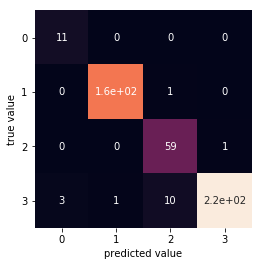

In [25]:
mat = confusion_matrix(y_pred,y_valid)

sns.heatmap(mat, square=True, annot=True, cbar=False)

plt.xticks(CLASS_INTEGERS + 0.5, CLASS_NAMES) # add half for nicer location
plt.yticks(CLASS_INTEGERS + 0.5, CLASS_NAMES,  rotation='horizontal') # add half for nicer location

plt.xlabel('predicted value')
plt.ylabel('true value')

In [26]:
score = classification_report(y_valid,y_pred)
print(score)
print("Accuracy score : {}".format(accuracy_score(y_valid,y_pred)))

             precision    recall  f1-score   support

        0.0       1.00      0.79      0.88        14
        1.0       0.99      0.99      0.99       156
        2.0       0.98      0.84      0.91        70
        3.0       0.94      1.00      0.97       219

avg / total       0.97      0.97      0.96       459

Accuracy score : 0.9651416122


In [28]:
def train_absolute(param,X,y,X_test,y_test):
    
    plst = param.items()
    
    num_boost_rounds = param['num_boost_round']
    
    score_training = 0
    score_testing = 0

    X_train, X_test = X, X_test
    y_train, y_test = y, y_test
    
    print("Train size : {} Test Size = {}".format(X_train.shape[0],X_test.shape[0]))
    
    dtrain = xgb.DMatrix(X_train, label=y_train)
    bst = xgb.train(params=plst,dtrain=dtrain,num_boost_round=num_boost_rounds,verbose_eval=2)

    y_train_pred = bst.predict(xgb.DMatrix(X_train))
    score = classification_report(y_train,y_train_pred)

    score_training += accuracy_score(y_train,y_train_pred)

    y_pred = bst.predict(xgb.DMatrix(X_test))
    score = classification_report(y_test,y_pred)

    score_testing += accuracy_score(y_test,y_pred)

    return score_training , score_testing

In [27]:
max_depth_arr = [7,8,9,10,11,12]
eta_arr = [0.05,0.1,0.2,0.3]
num_rounds_arr = [50,55,60,65,70,75]

In [32]:
dict_res_3_0_pareto = {}

### Lets Go through the Hyperparameter tuning process.

In [33]:
print(max_depth_arr)
print(eta_arr)
print(num_rounds_arr)

for depth in max_depth_arr :
    for eta in eta_arr:
        for num_round in num_rounds_arr:
            param['eta'] = eta
            param['max_depth'] = depth
            param['num_boost_round'] = num_round
            
            score_training,score_testing = train_absolute(param,X_Train,y_Train,X_valid,y_valid)
            str_1 = 'training_depth_{}_eta_{}_num_boost_round_{}_3_0_with_degenerate'.format(param['max_depth'],param['eta'],num_round)
            str_2 = 'testing_depth_{}_eta_{}_num_boost_round_{}_3_0_with_degenerate'.format(param['max_depth'],param['eta'],num_round)
            
            dict_res_3_0_pareto[str_1] = score_training
            dict_res_3_0_pareto[str_2] = score_testing
            
            print("depth = {} eta = {} num_round = {}".format(depth,eta,num_round))
            print('{} score {}'.format(str_1,score_training))
            print('{} score {}'.format(str_2,score_testing))
#             print(dict_res_3_1)

[7, 8, 9, 10, 11, 12]
[0.05, 0.1, 0.2, 0.3]
[50, 55, 60, 65, 70, 75]
Train size : 1832 Test Size = 459
depth = 7 eta = 0.05 num_round = 50
training_depth_7_eta_0.05_num_boost_round_50_3_0_with_degenerate score 0.999454148472
testing_depth_7_eta_0.05_num_boost_round_50_3_0_with_degenerate score 0.954248366013
Train size : 1832 Test Size = 459
depth = 7 eta = 0.05 num_round = 55
training_depth_7_eta_0.05_num_boost_round_55_3_0_with_degenerate score 0.999454148472
testing_depth_7_eta_0.05_num_boost_round_55_3_0_with_degenerate score 0.956427015251
Train size : 1832 Test Size = 459
depth = 7 eta = 0.05 num_round = 60
training_depth_7_eta_0.05_num_boost_round_60_3_0_with_degenerate score 1.0
testing_depth_7_eta_0.05_num_boost_round_60_3_0_with_degenerate score 0.956427015251
Train size : 1832 Test Size = 459
depth = 7 eta = 0.05 num_round = 65
training_depth_7_eta_0.05_num_boost_round_65_3_0_with_degenerate score 1.0
testing_depth_7_eta_0.05_num_boost_round_65_3_0_with_degenerate score 0.95

KeyboardInterrupt: 

### Interrupted the above session. Lets see the output so far

In [34]:
dict_res_3_0_pareto

{'testing_depth_10_eta_0.05_num_boost_round_50_3_0_with_degenerate': 0.9520697167755992,
 'testing_depth_10_eta_0.05_num_boost_round_55_3_0_with_degenerate': 0.954248366013072,
 'testing_depth_10_eta_0.05_num_boost_round_60_3_0_with_degenerate': 0.954248366013072,
 'testing_depth_10_eta_0.05_num_boost_round_65_3_0_with_degenerate': 0.954248366013072,
 'testing_depth_10_eta_0.05_num_boost_round_70_3_0_with_degenerate': 0.9586056644880174,
 'testing_depth_10_eta_0.05_num_boost_round_75_3_0_with_degenerate': 0.9629629629629629,
 'testing_depth_10_eta_0.1_num_boost_round_50_3_0_with_degenerate': 0.9651416122004357,
 'testing_depth_10_eta_0.1_num_boost_round_55_3_0_with_degenerate': 0.9629629629629629,
 'testing_depth_10_eta_0.1_num_boost_round_60_3_0_with_degenerate': 0.9629629629629629,
 'testing_depth_10_eta_0.1_num_boost_round_65_3_0_with_degenerate': 0.9629629629629629,
 'testing_depth_7_eta_0.05_num_boost_round_50_3_0_with_degenerate': 0.954248366013072,
 'testing_depth_7_eta_0.05_num